In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import re

# Use this if running this notebook from within its place in the truera repository.
sys.path.insert(0, "..")
from collections import defaultdict
from IPython.display import display
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text 
import numpy as np
import collections

# Load as keras model

In [3]:
# tf.compat.v1.disable_eager_execution()

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 7)])

In [5]:
from tensorflow_hub.module_v2 import resolve
import tensorflow_models as tfm

In [6]:
def load_tfhub_as_keras(handle):
    module_path = resolve(handle)
    return tf.keras.models.load_model(module_path)


In [7]:
preprocessor_handle = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_handle = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2"

preprocessor = load_tfhub_as_keras(preprocessor_handle)
encoder = load_tfhub_as_keras(encoder_handle).layers[-1]

2022-06-09 00:05:10.525807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-09 00:05:11.770048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7168 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


/data/anaconda/envs/demo3/lib/python3.9/site-packages/keras/engine/functional.py:566: UserWarning: Input dict contained keys ['masked_lm_positions'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [8]:
preprocessor.layers, encoder.layers

([<keras.engine.input_layer.InputLayer at 0x7f65d8b9b400>,
  <keras.layers.core.dense.Dense at 0x7f658a656880>])

## load existing checkpoint

In [9]:
model = tf.keras.models.load_model('/data/longterm/kaggle-covid-tweets/model/classifierbert-cnn')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [10]:
def model_weight_transfer(from_model, to_model):
    # ensure trainable_variables line up
    assert False not in [w1.name == w2.name for w1, w2 in zip(from_model.trainable_variables, to_model.trainable_variables)]
    from_weight_vals = {w.name: tf.keras.backend.get_value(w) for w in from_model.trainable_variables}
    for to_weight in to_model.trainable_variables:
        tf.keras.backend.set_value(to_weight, from_weight_vals[to_weight.name])
    

## Model Plots

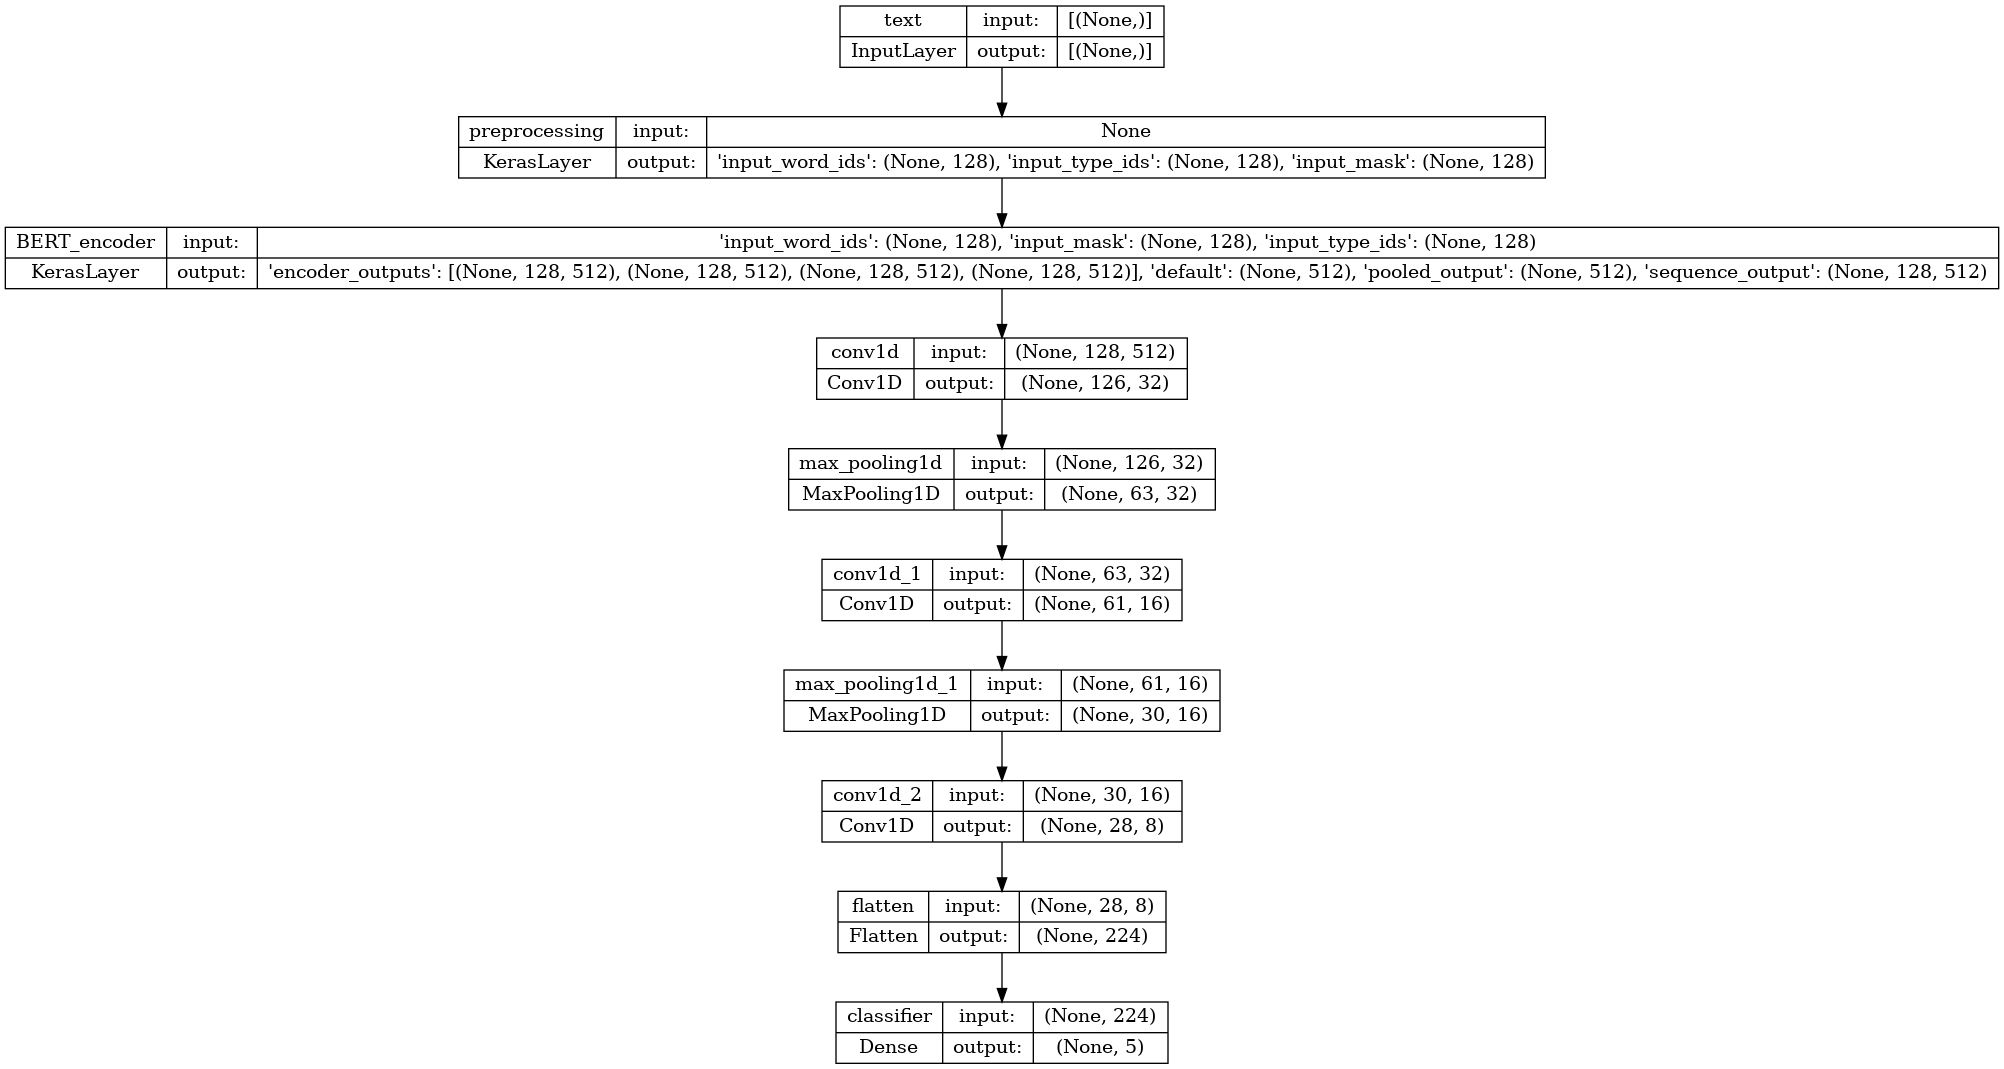

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

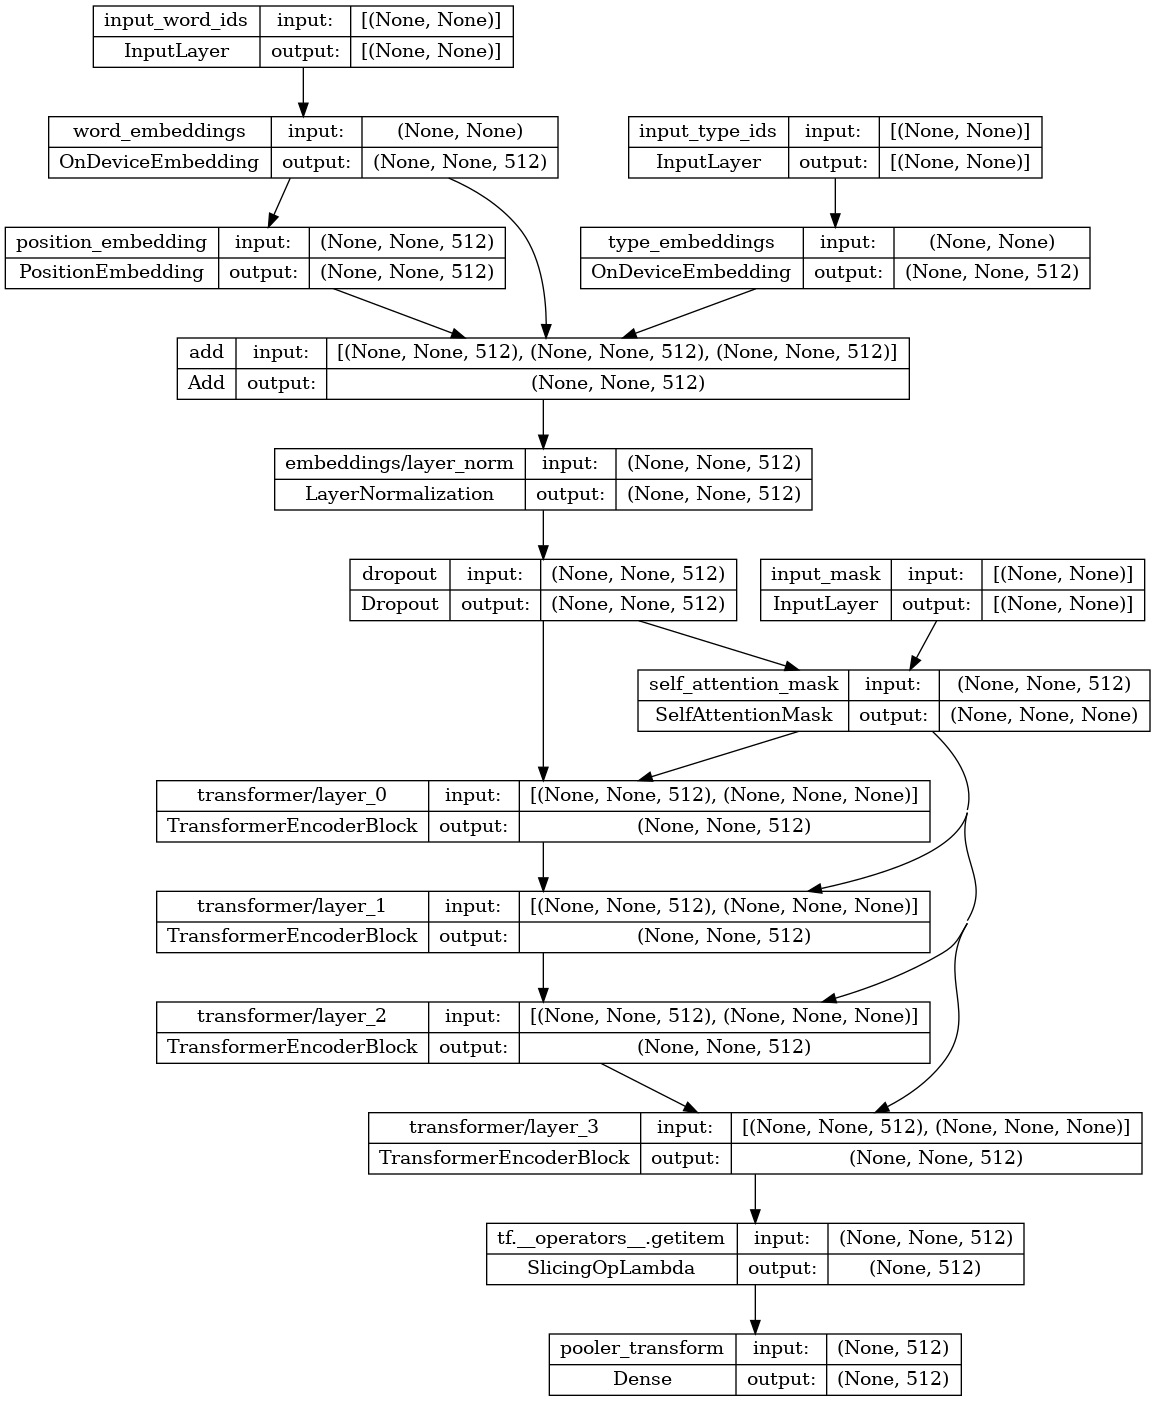

In [12]:
plot_model(encoder, show_shapes=True, show_layer_names=True)

## GradientTape on layer outputs

In [13]:
encoder_layer_names = {l.name: l for l in encoder.layers}
encoder_layer_names

{'input_word_ids': <keras.engine.input_layer.InputLayer at 0x7f65d00f6a00>,
 'word_embeddings': <official.nlp.modeling.layers.on_device_embedding.OnDeviceEmbedding at 0x7f65a0264640>,
 'input_type_ids': <keras.engine.input_layer.InputLayer at 0x7f65d00f73d0>,
 'position_embedding': <official.nlp.modeling.layers.position_embedding.PositionEmbedding at 0x7f65a0264820>,
 'type_embeddings': <official.nlp.modeling.layers.on_device_embedding.OnDeviceEmbedding at 0x7f65a0264430>,
 'add': <keras.layers.merging.add.Add at 0x7f65d0404d30>,
 'embeddings/layer_norm': <keras.layers.normalization.layer_normalization.LayerNormalization at 0x7f65a00ae490>,
 'dropout': <keras.layers.regularization.dropout.Dropout at 0x7f65a0118cd0>,
 'input_mask': <keras.engine.input_layer.InputLayer at 0x7f65d00f6e80>,
 'self_attention_mask': <official.nlp.modeling.layers.self_attention_mask.SelfAttentionMask at 0x7f65a00ae190>,
 'transformer/layer_0': <official.nlp.modeling.layers.transformer_encoder_block.Transforme

In [14]:
model_layer_names = {l.name: l for l in model.layers}
model_layer_names

{'text': <keras.engine.input_layer.InputLayer at 0x7f6588e11ca0>,
 'preprocessing': <keras.saving.saved_model.load.KerasLayer at 0x7f6588e2ecd0>,
 'BERT_encoder': <keras.saving.saved_model.load.KerasLayer at 0x7f6588e2ed60>,
 'conv1d': <keras.layers.convolutional.conv1d.Conv1D at 0x7f6588e2ef40>,
 'max_pooling1d': <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7f6588e2eee0>,
 'conv1d_1': <keras.layers.convolutional.conv1d.Conv1D at 0x7f6588d2b760>,
 'max_pooling1d_1': <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7f664b881a30>,
 'conv1d_2': <keras.layers.convolutional.conv1d.Conv1D at 0x7f664b8811c0>,
 'flatten': <keras.layers.reshaping.flatten.Flatten at 0x7f6588d90040>,
 'classifier': <keras.layers.core.dense.Dense at 0x7f6588d950a0>}

In [15]:
word_embedding_output_tensor = encoder.layers[1].output
word_embedding_output_tensor

<KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'word_embeddings')>

In [16]:
encoder.output

{'sequence_output': <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_3')>,
 'pooled_output': <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'pooler_transform')>,
 'encoder_outputs': [<KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_0')>,
  <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_1')>,
  <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_2')>,
  <KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'transformer/layer_3')>]}

In [17]:
post_embedding_model = tf.keras.Model(
    inputs=[word_embedding_output_tensor, encoder_layer_names['input_type_ids'].input, encoder_layer_names['input_mask'].input], 
    outputs=encoder.output['sequence_output']
)

In [18]:
model.layers[3].input

<KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>

In [19]:
outer_model = tf.keras.Model(
    inputs=[model.layers[3].input], 
    outputs=model.output
)

In [20]:
model_weight_transfer(model.layers[2], encoder)

In [21]:
test_constant = tf.constant(["word one word two", "another sentence to compare against"])
with tf.GradientTape(persistent=True) as tape:
    enc_input = preprocessor(test_constant)
    
    word_embedding_tensor = encoder.layers[1](enc_input['input_word_ids'])
    tape.watch(word_embedding_tensor)

    enc_outputs = post_embedding_model([word_embedding_tensor, enc_input['input_type_ids'], enc_input['input_mask']])
    tape.watch(enc_outputs)

    outer_output = outer_model(enc_outputs)

    # outputs = encoder(enc_input)
    # output = tf.reduce_sum(outputs['sequence_output'])

inner_gradients = tape.gradient(enc_outputs, word_embedding_tensor)
outer_gradients = tape.gradient(outer_output, enc_outputs,)
comb_gradients = tape.gradient(outer_output, word_embedding_tensor)

2022-06-09 00:05:35.240416: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-06-09 00:05:35.394754: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


In [22]:
outer_output, model(test_constant)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.02252408, 0.03340827, 0.12915492, 0.6150217 , 0.19989099],
        [0.12427575, 0.12351469, 0.27191117, 0.3739182 , 0.10638017]],
       dtype=float32)>,
 <tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.02252228, 0.03341732, 0.12913115, 0.6149948 , 0.19993445],
        [0.12426497, 0.12349026, 0.27189323, 0.37397388, 0.10637773]],
       dtype=float32)>)

In [23]:
comb_gradients

<tf.Tensor: shape=(2, 128, 512), dtype=float32, numpy=
array([[[ 2.9704528e-10,  3.4421419e-09, -4.8914881e-09, ...,
          5.6167155e-09,  4.7368336e-09, -2.2038762e-09],
        [-8.9345153e-09,  1.1360383e-08, -1.4357865e-08, ...,
          1.5219566e-08,  1.8343805e-08,  6.2584689e-09],
        [ 4.6096922e-09,  7.8380173e-09,  8.6989154e-09, ...,
          2.2932820e-09,  5.6999960e-09, -6.5894099e-09],
        ...,
        [ 9.4859632e-12,  4.2673094e-11, -1.1231307e-10, ...,
          2.0621860e-11, -5.2341645e-11,  6.2655749e-11],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.

In [24]:
outer_gradients

<tf.Tensor: shape=(2, 128, 512), dtype=float32, numpy=
array([[[-2.5379521e-11,  6.1289501e-11,  1.0793443e-11, ...,
          1.9993224e-11, -7.1612140e-11,  4.4321154e-11],
        [-5.6486264e-11,  2.5215739e-11, -6.9946139e-11, ...,
         -5.1102338e-11, -8.0152669e-11, -1.4468863e-11],
        [ 1.0537564e-10, -7.4031808e-11, -1.3461704e-11, ...,
          1.7071759e-11, -2.2608212e-11, -1.1352618e-10],
        ...,
        [-1.2447671e-11,  3.5162604e-12, -1.8617906e-11, ...,
          8.1794562e-12,  2.2775117e-12,  7.5311285e-12],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.

In [25]:
inner_gradients

<tf.Tensor: shape=(2, 128, 512), dtype=float32, numpy=
array([[[-2.35302258e+01,  8.86870384e+00,  7.68673897e+00, ...,
          2.74800563e+00, -8.71699429e+00,  2.45719004e+00],
        [-2.14117947e+01,  4.09604607e+01, -4.24357452e+01, ...,
          1.06120050e+00, -3.40362663e+01, -7.62129593e+00],
        [-1.15976992e+01,  2.18188934e+01, -6.42701912e+00, ...,
          7.39400959e+00, -1.13035030e+01, -1.64940929e+01],
        ...,
        [ 5.02356827e-01,  1.98667124e-01, -3.01021159e-01, ...,
         -4.39087301e-03, -2.25818440e-01,  9.81237963e-02],
        [ 4.15651113e-01, -4.85871360e-03, -1.09806314e-01, ...,
          3.05328891e-03, -2.63953239e-01, -4.31704288e-03],
        [ 5.95008016e-01, -9.65791196e-03, -3.47437263e-01, ...,
          1.43042952e-02, -4.73970413e-01,  2.54449368e-01]],

       [[-2.71109734e+01, -1.19902539e+00,  3.07619095e+00, ...,
          1.29897442e+01, -2.06306152e+01,  2.45621910e+01],
        [-3.87126274e+01,  7.52465820e+00, -1.28

In [33]:
np.matmul(inner_gradients.numpy(), outer_gradients.numpy().T)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 128 is different from 512)

# Inject model layer

In [19]:
def recurse_outputs(obj, prefix=[]):
    ret = {}
    if tf.is_tensor(obj):
        return {obj.ref(): prefix}
    elif isinstance(obj, collections.abc.Mapping):
        for key, val in obj.items():
            ret.update(recurse_outputs(val, prefix + [key]))
    elif isinstance(obj, collections.abc.Iterable):
        for i, elem in enumerate(obj):
            ret.update(recurse_outputs(elem, prefix + [i]))
    else:
        print(type(obj))
    return ret

In [20]:
tensor_mapping = recurse_outputs(model.layers[2].inbound_nodes[0].outputs)
tensor_mapping

{<Reference wrapping <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['pooled_output'],
 <Reference wrapping <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['default'],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['sequence_output'],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  0],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  1],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  2],
 <Reference wrapping <KerasTensor: shape=(None, 128, 512) dtype=float32 (created by layer 'BERT_encoder')>>: ['encoder_outputs',
  3]}

In [21]:
list(tensor_mapping.keys())[0]

<Reference wrapping <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'BERT_encoder')>>

In [22]:
model.layers[-2].inbound_nodes[0].__dict__

{'layer': <keras.layers.reshaping.flatten.Flatten at 0x7f9556279fa0>,
 'is_input': False,
 'outputs': <KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>,
 'call_args': (<KerasTensor: shape=(None, 28, 8) dtype=float32 (created by layer 'conv1d_2')>,),
 'call_kwargs': {},
 '_flat_arguments': [<KerasTensor: shape=(None, 28, 8) dtype=float32 (created by layer 'conv1d_2')>],
 '_single_positional_tensor_passed': True,
 '_keras_inputs': [<KerasTensor: shape=(None, 28, 8) dtype=float32 (created by layer 'conv1d_2')>],
 '_keras_inputs_ids_and_indices': [('140257701597632', 0)],
 'flat_input_ids': ['140257701597632'],
 'flat_output_ids': ['140257701391472']}

In [23]:
model.layers[-1].inbound_nodes[0].__dict__

{'layer': <keras.layers.core.dense.Dense at 0x7f955627d280>,
 'is_input': False,
 'outputs': <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'classifier')>,
 'call_args': (<KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>,),
 'call_kwargs': {},
 '_flat_arguments': [<KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>],
 '_single_positional_tensor_passed': True,
 '_keras_inputs': [<KerasTensor: shape=(None, 224) dtype=float32 (created by layer 'flatten')>],
 '_keras_inputs_ids_and_indices': [('140257701391472', 0)],
 'flat_input_ids': ['140257701391472'],
 'flat_output_ids': ['140257701391136']}

In [24]:
def get_layer_input_paths(model):
    layer_outputs = {}
    layer_input_paths = {}
    
    # Outputs of each layer
    for layer in model.layers:
        layer_outputs[layer.name] = recurse_outputs(layer.output, [layer.name])

    # Path to inputs of each layer
    for layer in model.layers:
        out_nodes = set(layer.outbound_nodes)
        for out_node in out_nodes:
            next_layer = out_node.layer
            args = out_node.call_args
            kwargs = out_node.call_kwargs
            
            arg_paths = []
            for i, arg in enumerate(args):
                if tf.is_tensor(arg):
                    arg_path = layer_outputs[layer.name][arg.ref()]
                elif isinstance(arg, collections.abc.Mapping):
                    arg_path = {key: layer_outputs[layer.name][arg.ref()] for key, arg in arg.items()}
                elif isinstance(arg, collections.abc.Iterable):
                    arg_path = [layer_outputs[layer.name][arg.ref()] for j, arg in enumerate(arg)]
                arg_paths.append(arg_path)

            kwarg_paths = {}
            for key, arg in kwargs.items():
                kwarg_paths[key] = {}
                if tf.is_tensor(arg):
                    kwarg_paths[key] = layer_outputs[layer.name][arg.ref()]
                elif isinstance(arg, collections.abc.Mapping):
                    kwarg_paths[key] = {key: layer_outputs[layer.name][arg.ref()] for key, arg in arg.items()}
                elif isinstance(arg, collections.abc.Iterable):
                    kwarg_paths[key] = [layer_outputs[layer.name][arg.ref()] for arg in arg]
            
            if next_layer.name not in layer_input_paths:
                layer_input_paths[next_layer.name] = {"args": arg_paths, "kwargs": kwarg_paths}
            else:
                layer_input_paths[next_layer.name]['args'].extend(arg_paths) 
                layer_input_paths[next_layer.name]['kwargs'].update(kwarg_paths) 
        
    return layer_input_paths

layer_input_paths = get_layer_input_paths(model)
layer_input_paths

{'preprocessing': {'args': [['text']], 'kwargs': {}},
 'BERT_encoder': {'args': [{'input_word_ids': ['preprocessing',
     'input_word_ids'],
    'input_mask': ['preprocessing', 'input_mask'],
    'input_type_ids': ['preprocessing', 'input_type_ids']}],
  'kwargs': {}},
 'conv1d': {'args': [['BERT_encoder', 'sequence_output']], 'kwargs': {}},
 'max_pooling1d': {'args': [['conv1d']], 'kwargs': {}},
 'conv1d_1': {'args': [['max_pooling1d']], 'kwargs': {}},
 'max_pooling1d_1': {'args': [['conv1d_1']], 'kwargs': {}},
 'conv1d_2': {'args': [['max_pooling1d_1']], 'kwargs': {}},
 'flatten': {'args': [['conv1d_2']], 'kwargs': {}},
 'classifier': {'args': [['flatten']], 'kwargs': {}}}

In [25]:
def lookup_arg_path(path, model, layer_subs=None):
    layer_name = path[0]
    
    if layer_subs and layer_name in layer_subs:
        out = layer_subs[layer_name]
    else:
        model_layer_names = {l.name: l for l in model.layers}
        layer = model_layer_names[layer_name]
        out = layer.output

    for part in path[1:]:
        if isinstance(out, collections.abc.Mapping):
            out = out[part]
        elif isinstance(part, int) and isinstance(out, collections.abc.Iterable):
            out = out[part]
        else:
            raise ValueError(f"Invalid part path {part} for object {out}")
    return out


In [26]:
def get_layer_exec_order(nodes_by_depth):
    layer_paths = {}
    def helper(depth=0):
        if depth not in nodes_by_depth:
            return
        else:
            for node in nodes_by_depth[depth]:
                inbound_layers = node.inbound_layers

                if isinstance(inbound_layers, list):
                    inbound_layers = list(set(inbound_layers))
                else:
                    inbound_layers = [inbound_layers]

                for layer in inbound_layers:
                    if node.outbound_layer in layer_paths:
                        layer_paths[layer] = [node.outbound_layer] + layer_paths[node.outbound_layer]
                    else:
                        layer_paths[layer] = [node.outbound_layer]
            helper(depth=depth+1)
    helper()
    return layer_paths
layer_exec_order = get_layer_exec_order(model._nodes_by_depth)
layer_exec_order

{<keras.layers.reshaping.flatten.Flatten at 0x7f9556279fa0>: [<keras.layers.core.dense.Dense at 0x7f955627d280>],
 <keras.layers.convolutional.conv1d.Conv1D at 0x7f95562170a0>: [<keras.layers.reshaping.flatten.Flatten at 0x7f9556279fa0>,
 <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7f962085d490>: [<keras.layers.convolutional.conv1d.Conv1D at 0x7f95562170a0>,
 <keras.layers.convolutional.conv1d.Conv1D at 0x7f9556bc0cd0>: [<keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7f962085d490>,
 <keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7f9556193520>: [<keras.layers.convolutional.conv1d.Conv1D at 0x7f9556bc0cd0>,
 <keras.layers.convolutional.conv1d.Conv1D at 0x7f95562b0c70>: [<keras.layers.pooling.max_pooling1d.MaxPooling1D at 0x7f9556193520>,
 <keras.saving.saved_model.load.KerasLayer at 0x7f95562b0ee0>: [<keras.layers.convolutional.conv1d.Conv1D at 0x7f95562b0c70>,
 <keras.saving.saved_model.load.KerasLayer at 0x7f95562b09d0>: [<keras.saving.saved_model.load.KerasLaye

In [27]:
def get_layer_input_tensors(layer, model, layer_subs=None):
    layer_name = layer.name
    input_paths = layer_input_paths[layer_name]
    args = input_paths['args']
    kwargs = input_paths['kwargs']


    # fetch input args for this layer
    input_args = []
    for arg in args:
        if isinstance(arg, collections.abc.Mapping):
            input_args.append({k: lookup_arg_path(path, model, layer_subs) for k, path in arg.items()})
        elif isinstance(arg, collections.abc.Iterable):
            if len(arg) <= 0:
                pass
            elif isinstance(arg[0], str):
                # one path
                input_args.append(lookup_arg_path(arg, model, layer_subs))
            elif isinstance(arg[0], collections.abc.Iterable):
                 input_args.append([lookup_arg_path(path, model, layer_subs) for path in arg])
    input_args = tuple(input_args)

    input_kwargs = {}
    for key, arg in kwargs.items():
        if isinstance(arg, collections.abc.Mapping):
            input_kwargs[key] = {k: lookup_arg_path(path, model, layer_subs) for k, path in arg.items()}
        elif isinstance(arg, collections.abc.Iterable):
            if len(arg) <= 0:
                pass
            elif isinstance(arg[0], str):
                # one path
                input_kwargs[key] = lookup_arg_path(arg, model, layer_subs)
            elif isinstance(arg[0], collections.abc.Iterable):
                 input_kwargs[key] = [lookup_arg_path(path, model, layer_subs) for path in arg]
    
    return input_args, input_kwargs


def replace_layer(layer, model, replacement, flatten=False):
    input_args, input_kwargs = get_layer_input_tensors(layer, model)
    output = replacement(*input_args, **input_kwargs)
    subs = {layer.name: output}

    next_layers = layer_exec_order[layer]

    for next_layer in next_layers:
        input_args, input_kwargs = get_layer_input_tensors(next_layer, model, layer_subs=subs)
        output = next_layer(*input_args, **input_kwargs)
        subs = {next_layer.name: output}
            
    return tf.keras.Model(inputs=model.inputs, outputs=output)

new_model = replace_layer(model.layers[2], model, encoder)
model_weight_transfer(model, new_model)

new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

2022-06-08 22:04:34.036660: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.
2022-06-08 22:04:34.149321: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.


 flatten (Flatten)              (None, 224)          0           ['conv1d_2[1][0]']               
                                                                                                  
 classifier (Dense)             (None, 5)            1125        ['flatten[1][0]']                
                                                                                                  
Total params: 28,815,901
Trainable params: 28,815,901
Non-trainable params: 0
__________________________________________________________________________________________________


In [28]:
# def layer_clone_function(layer):
#     print(layer.name)
#     if 'handle' in layer.get_config():
#         handle = layer.get_config()['handle']
#         return load_tfhub_as_keras(handle)
#     else:
#         return layer.__class__.from_config(layer.get_config())

# cloned_model = tf.keras.models.clone_model(model, clone_function=layer_clone_function)
# clonsed_model = model.__class__.from_config(model.get_config())

In [29]:
test_input = tf.constant(["this is a new word"])
model(test_input), new_model(test_input)

2022-06-08 22:04:34.996659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


(<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.01866247, 0.03380817, 0.09248857, 0.575172  , 0.27986875]],
       dtype=float32)>,
 <tf.Tensor: shape=(1, 5), dtype=float32, numpy=
 array([[0.01867338, 0.03381346, 0.09251021, 0.5751604 , 0.2798426 ]],
       dtype=float32)>)

In [30]:
enc_input = preprocessor(test_input)
model_weight_transfer(model.layers[2], encoder)
model.layers[2](enc_input)['sequence_output'], encoder(enc_input)['sequence_output']

2022-06-08 22:04:37.852656: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62509056 exceeds 10% of free system memory.


(<tf.Tensor: shape=(1, 128, 512), dtype=float32, numpy=
 array([[[-0.01783409,  0.5624505 ,  0.1815386 , ..., -1.1020133 ,
           0.06424139,  0.2002483 ],
         [-0.4837256 ,  0.9811252 , -0.17309827, ..., -0.4301881 ,
          -0.2675475 ,  0.98330647],
         [-0.46115863,  1.4171292 , -0.5399093 , ..., -0.74740034,
          -0.31318116,  0.532528  ],
         ...,
         [ 0.06794655,  0.8265918 , -0.0640971 , ..., -0.58697337,
          -0.03739796,  0.6674942 ],
         [ 0.0544386 ,  0.6643322 , -0.09645768, ..., -0.75264543,
           0.10507973,  0.48119366],
         [ 0.10319887,  0.8411214 , -0.10416265, ..., -0.41189826,
           0.42923623,  0.08971641]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 128, 512), dtype=float32, numpy=
 array([[[-0.01753234,  0.562736  ,  0.18134502, ..., -1.102403  ,
           0.06434195,  0.20007703],
         [-0.48316184,  0.98108596, -0.17311603, ..., -0.43013665,
          -0.26701272,  0.98289275],
         [-0.46080756, 

In [31]:
new_model.layers[2].layers[1].output

<KerasTensor: shape=(None, None, 512) dtype=float32 (created by layer 'word_embeddings')>

In [1]:
pre_model = tf.keras.Model(inputs=new_model.inputs, outputs=new_model.layers[2].output)

NameError: name 'tf' is not defined

In [ ]:
post_model = tf.keras.Model(
    inputs=[new_model.layers[2].layers[1].output, encoder_layer_names['input_type_ids'].input, encoder_layer_names['input_mask'].input], 
    outputs=new_model.output
)

ValueError: Found input tensor cannot be reached given provided output tensors. Please make sure the tensor KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.string, name='text'), name='text', description="created by layer 'text'") is included in the model inputs when building functional model.

In [ ]:
test_constant = tf.constant(["word one word two", "another sentence to compare against"])


with tf.GradientTape() as tape:
    enc_input = preprocessor(test_constant)
    
    word_embedding_tensor = encoder.layers[1](enc_input['input_word_ids'])
    tape.watch(word_embedding_tensor)

    outputs = post_embedding_model([word_embedding_tensor, enc_input['input_type_ids'], enc_input['input_mask']])

    # outputs = encoder(enc_input)
    # output = tf.reduce_sum(outputs['sequence_output'])

gradients = tape.gradient(outputs, word_embedding_tensor)
gradients

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.int32, name='input_word_ids'), name='input_word_ids', description="created by layer 'input_word_ids'") at layer "word_embeddings". The following previous layers were accessed without issue: []

# Load from checkpoint

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])


In [ ]:
model = tf.keras.models.load_model('/data/longterm/kaggle-covid-tweets/model/classifierbert-cnn')

2022-06-05 09:36:44.853260: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 09:36:45.778340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20634 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6
2022-06-05 09:36:45.927385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [ ]:
# preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
# encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
preprocessor = model.layers[1]
encoder = model.layers[2]
preprocessor, encoder

(<keras.saving.saved_model.load.KerasLayer at 0x7f4ff3364070>,
 <keras.saving.saved_model.load.KerasLayer at 0x7f4ff3364850>)

In [ ]:
test_input = tf.constant(["word one word two"])
encoder_input = preprocessor(test_input)
encoder_input

{'input_type_ids': <tf.Tensor 'preprocessing_1/cond/Identity_1:0' shape=(1, 128) dtype=int32>,
 'input_word_ids': <tf.Tensor 'preprocessing_1/cond/Identity_2:0' shape=(1, 128) dtype=int32>,
 'input_mask': <tf.Tensor 'preprocessing_1/cond/Identity:0' shape=(1, 128) dtype=int32>}

In [ ]:
# node of interest
# op_name = "model/bert_encoder/word_embeddings/Gather"
# op_name = "model/bert_encoder/word_embeddings/Reshape_1"
op_name = "word_embeddings/Reshape_1"
tensor_name = f"{op_name}:0"
op_name, tensor_name

graph = model.signatures['serving_default'].graph

func = [func for func in graph._functions.values() if func.graph.name == "bert_encoder_layer_call_and_return_conditional_losses"][0]
func_graph = func.graph

embedding_output_tensor = func_graph.get_tensor_by_name(tensor_name)
seq_output_tensor = func_graph.outputs[-1]

embedding_output_tensor, seq_output_tensor 

(<tf.Tensor 'word_embeddings/Reshape_1:0' shape=(None, None, 512) dtype=float32>,
 <tf.Tensor 'Identity_5:0' shape=(None, None, 512) dtype=float32>)

In [ ]:
# gradient op
grad_op = tf.gradients(seq_output_tensor, embedding_output_tensor, [embedding_output_tensor])

In [ ]:
model

In [ ]:
# encoder_graph = model.layers[2]._autographed_call().trace_0.graph
# with encoder_graph.as_default():
#     writer = tf.compat.v1.summary.FileWriter("enc_output", encoder_graph)

In [ ]:
embedding_matrix = model.layers[2].trainable_weights[0]
embedding_matrix.shape

TensorShape([30522, 512])

In [ ]:
operations = func_graph.get_operations() 
operations

[<tf.Operation 'inputs' type=Placeholder>,
 <tf.Operation 'inputs_1' type=Placeholder>,
 <tf.Operation 'inputs_2' type=Placeholder>,
 <tf.Operation 'word_embeddings_gather_resource' type=Placeholder>,
 <tf.Operation 'position_embedding_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'type_embeddings_matmul_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'embeddings_layer_norm_batchnorm_mul_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'embeddings_layer_norm_batchnorm_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_query_einsum_einsum_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_query_add_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_key_einsum_einsum_readvariableop_resource' type=Placeholder>,
 <tf.Operation 'transformer_layer_0_self_attention_key_add_readvariableop_resource' type=Placeholder>,
 <tf.Operatio

# GradientTape on main graph tensors

In [ ]:
with tf.GradientTape() as tape:
    # Forward pass.
    t = tf.compat.v1.get_default_graph().get_tensor_by_name("Identity_82:0")
    # embedding_output_tensor, seq_output_tensor
    tape.watch(t)
    
    outputs = model(test_input)
    output = tf.reduce_sum(outputs)

# Get gradients of the loss wrt the weights.
gradients = tape.gradient(output, t)


In [ ]:
gradients is None

True

# GradientTape on local KerasLayer function graph tensors

In [ ]:
with tf.GradientTape() as tape:
    # Forward pass.
    # embedding_output_tensor, seq_output_tensor
    tape.watch(embedding_output_tensor)
    
    encoder(preprocessor(tf.constant(["word one word two"])))

    outputs = model(test_input)
    output = tf.reduce_sum(outputs)

# Get gradients of the loss wrt the weights.
gradients = tape.gradient(output, embedding_output_tensor)


In [ ]:
gradients

In [ ]:
out_tensor = model._run_internal_graph(tf.constant(["number one"]))
def traverse(tensor):
    print(tensor.name)
    if not tensor.op:
        return
    elif tensor.op.inputs:
        for i in tensor.op.inputs:
            traverse(i)
traverse(out_tensor)

classifier_3/Softmax:0
classifier_3/BiasAdd:0
classifier_3/MatMul:0
flatten_3/Reshape:0
conv1d_2_3/Relu:0
conv1d_2_3/BiasAdd:0
conv1d_2_3/Conv1D/Squeeze:0
conv1d_2_3/Conv1D:0
conv1d_2_3/Conv1D/ExpandDims:0
max_pooling1d_1_3/Squeeze:0
max_pooling1d_1_3/MaxPool:0
max_pooling1d_1_3/ExpandDims:0
conv1d_1_3/Relu:0
conv1d_1_3/BiasAdd:0
conv1d_1_3/Conv1D/Squeeze:0
conv1d_1_3/Conv1D:0
conv1d_1_3/Conv1D/ExpandDims:0
max_pooling1d_4/Squeeze:0
max_pooling1d_4/MaxPool:0
max_pooling1d_4/ExpandDims:0
conv1d_5/Relu:0
conv1d_5/BiasAdd:0
conv1d_5/Conv1D/Squeeze:0
conv1d_5/Conv1D:0
conv1d_5/Conv1D/ExpandDims:0
BERT_encoder_5/cond/Identity_6:0
BERT_encoder_5/cond:6
keras_learning_phase:0
keras_learning_phase/input:0
preprocessing_6/cond/Identity:0
preprocessing_6/cond:0
keras_learning_phase:0
keras_learning_phase/input:0
Const_12:0
StatefulPartitionedCall:0
Const:0
preprocessing_6/cond/Identity_1:0
preprocessing_6/cond:1
keras_learning_phase:0
keras_learning_phase/input:0
Const_12:0
StatefulPartitionedCa

# Execution tf.gradients op

In [ ]:
init = tf.compat.v1.global_variables_initializer()

with tf.compat.v1.Session() as sess:
    sess.run(init)
    sess.run(tf.compat.v1.tables_initializer())

    word_ids = encoder_input['input_word_ids'].eval()
    embedding_matrix_vals = embedding_matrix.eval()
    word_embedding_vals = tf.gather(embedding_matrix_vals, word_ids).eval()

with tf.compat.v1.Session() as sess:
    feed_dict = {embedding_output_tensor.name: word_embedding_vals}
    sess.run(grad_op, feed_dict=feed_dict)
    # model(tf.constant(["word one word two"]))
    # indices = gradients.indices.eval()
    # values = gradients.values.eval()

2022-06-05 09:19:50.916670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20634 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6
2022-06-05 09:19:56.963227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20634 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


TypeError: Cannot interpret feed_dict key as Tensor: The name 'word_embeddings/Reshape_1:0' refers to a Tensor which does not exist. The operation, 'word_embeddings/Reshape_1', does not exist in the graph.

In [ ]:
values = np.load("values.npy")
indices = np.load("indices.npy")
we_outputs = np.load("we_outputs.npy")

In [ ]:
we_outputs

array([( 96,), (104,), (145,), ( 59,), (115,), ( 85,), (  0,), (  0,),
       ( 44,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       ( 44,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       ( 48,), (253,), (111,), ( 60,), (115,), ( 85,), (  0,), (  0,),
       (  9,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (108,), (111,), ( 99,), ( 97,), (108,), (104,), (111,), (115,),
       (116,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (208,), (201,), (243,), ( 12,), (115,), ( 85,), (  0,), (  0,),
       ( 26,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       ( 30,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,), (  0,),
       (229,), (121,), (  9,), (254,), ( 34,), ( 81,), ( 60,), (242,),
       (192,), (197,), (252,), ( 12,), (115,), ( 85,), (  0,), (  0,),
      

In [ ]:
indices

array([ 101, 2773, 2028, 2773, 2048,  102,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
values.shape, values

((128, 512),
 array([[-3.8966417e-09, -5.2767932e-09,  4.3688053e-10, ...,
         -6.0606237e-10, -1.4775993e-09,  7.6429298e-09],
        [-1.2371629e-08, -1.3504893e-08,  2.2429301e-09, ...,
          6.0763745e-09, -9.0240544e-09,  8.8282892e-09],
        [-1.0507111e-09, -1.0066673e-08,  9.6981916e-09, ...,
          1.4974298e-10,  2.6738209e-09, -3.0488343e-09],
        ...,
        [-3.3865962e-11,  2.2052631e-12,  3.9422710e-12, ...,
          8.1435643e-11,  2.7550151e-11,  8.3780108e-11],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32))

In [ ]:
values